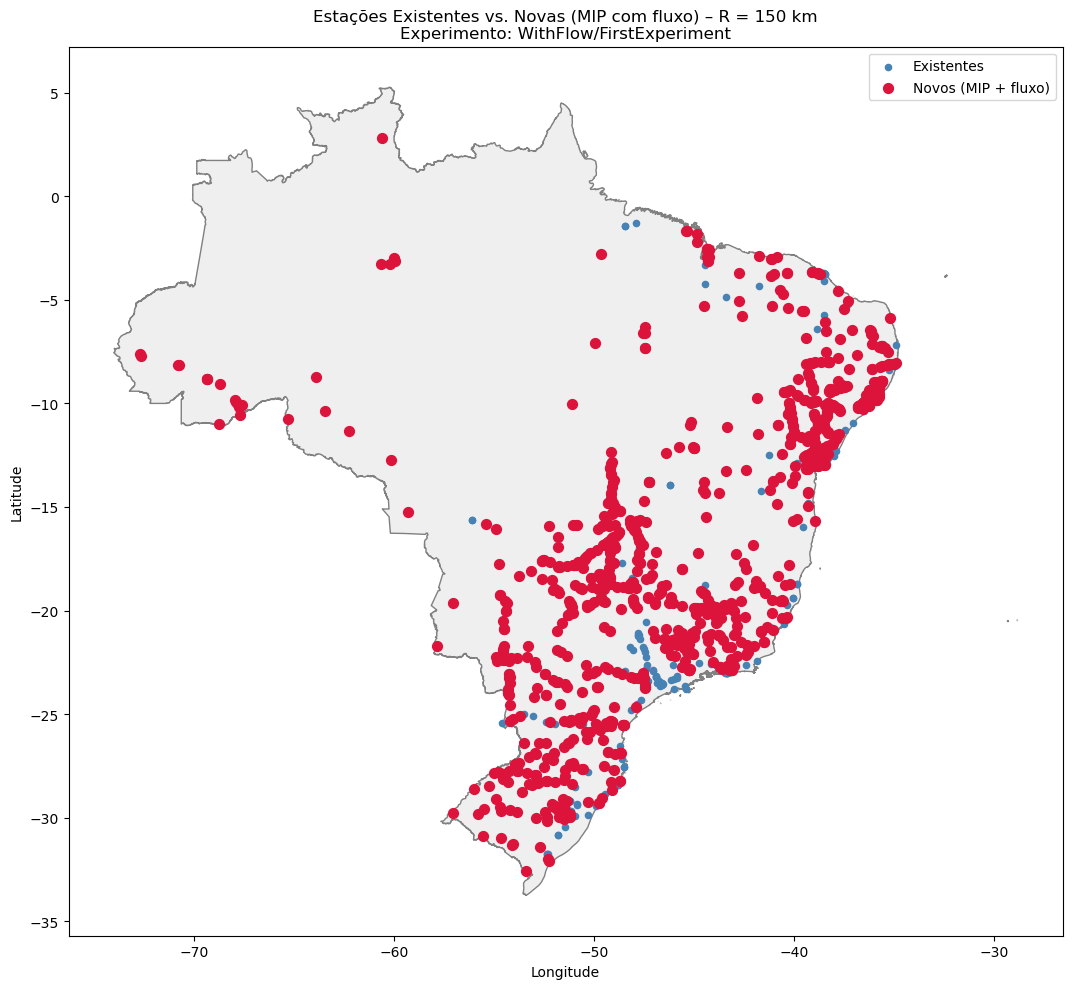

In [6]:
# %% [markdown]
# ## Visualização dos pontos existentes e dos novos (MIP com fluxo)
# Experimento: WithFlow/FirstExperiment

# %%
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
from pathlib import Path

# ─────────── ENCONTRA CACHE DINAMICAMENTE ───────────
HERE = Path().resolve()  # se estiver em um .py use Path(__file__).parent
CUR = HERE
while CUR != CUR.parent:
    if (CUR / "cache").is_dir():
        CACHE = CUR / "cache"
        break
    CUR = CUR.parent
else:
    raise FileNotFoundError(f"Não achei pasta 'cache' acima de {HERE}")

# ─────────── CONFIGURAÇÕES ───────────
PARQUET_DIR = CACHE / "parquet"
GRAPHML     = CACHE / "graph_Brazil.graphml"

# experimento a visualizar
EXPERIMENTO = "WithFlow/FirstExperiment"
OUTPUT_DIR  = PARQUET_DIR / EXPERIMENTO

# ─────────── CARREGA GRAFO ───────────
G = ox.load_graphml(str(GRAPHML))

# ─────────── CARREGA DADOS ───────────
# pontos existentes
sup = pd.read_parquet(PARQUET_DIR / "supply_existing.parquet")
# novos pontos do experimento com fluxo
new = pd.read_parquet(OUTPUT_DIR / "sites_new_mip_withflow_optional.parquet")

# ─────────── MAPEAR LON/LAT VIA GRAFO ───────────
lon_map = {n: d["x"] for n, d in G.nodes(data=True)}
lat_map = {n: d["y"] for n, d in G.nodes(data=True)}
sup["lon"] = sup["node"].map(lon_map)
sup["lat"] = sup["node"].map(lat_map)

# garantir lat/lon em `new`
if "lon" not in new or "lat" not in new:
    new["lon"] = new["node"].map(lon_map)
    new["lat"] = new["node"].map(lat_map)

# ─────────── GEO DATAFRAMES ───────────
g_exist = gpd.GeoDataFrame(
    sup,
    geometry=gpd.points_from_xy(sup.lon, sup.lat),
    crs="EPSG:4326"
)
g_new = gpd.GeoDataFrame(
    new,
    geometry=gpd.points_from_xy(new.lon, new.lat),
    crs="EPSG:4326"
)

# ─────────── CARREGA SHAPEFILE DO BRASIL ───────────
br_shp = CUR / "dados" / "BR_Pais_2023" / "BR_Pais_2023.shp"
if br_shp.exists():
    brasil = gpd.read_file(br_shp)
else:
    brasil = None

# ─────────── PLOT ───────────
fig, ax = plt.subplots(figsize=(12, 10))

if brasil is not None:
    brasil.plot(ax=ax, color="#EFEFEF", edgecolor="gray")

g_exist.plot(
    ax=ax,
    marker="o",
    color="steelblue",
    markersize=20,
    label="Existentes",
    zorder=2
)
g_new.plot(
    ax=ax,
    marker="o",
    color="crimson",
    markersize=50,
    label="Novos (MIP + fluxo)",
    zorder=3
)

ax.set_title(
    f"Estações Existentes vs. Novas (MIP com fluxo) – R = 150 km\n"
    f"Experimento: {EXPERIMENTO}"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()